In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN_test, CNN_pool, CNN_var
from networks.tests import VisionTransformer
import matplotlib.pyplot as plt
import pyreadr
from scipy.integrate import quad

In [2]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [3]:
def corr_func(h, method, r, s):
    if method=="powexp":
        res = np.exp(-np.power((h/r),s))
    elif method=="brown":
        res = np.power((h/r),s)
    return res    

In [4]:
def error_function(h, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    error = np.power(corr_func(h, method, r_true, s_true)- corr_func(h, method, r_est, s_est),2)
    return error

In [5]:
def get_imse(data, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (method, pred, params))
    return error

In [6]:
def get_metrics(pred, param, method):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse = np.mean(np.array([get_imse(x, method) for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"IMSE: {np.round(imse,2)}")    
    #print(f"Bias: {np.round(bias,2)}")

# Results for 3D Model

## Brown

In [7]:
# Dataloader
exp = "exp_4_1"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [8]:
#Load model
net = CNN_test(channels=5)
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [9]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [10]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [11]:
# Brown metrics
get_metrics(pred_tf,param_tf, "brown")

RMSE: [0.44 0.19]
MAE: [0.34 0.15]
IMSE: 20358.8


In [12]:
# Plot results
n_comb = 25
n_each = 20

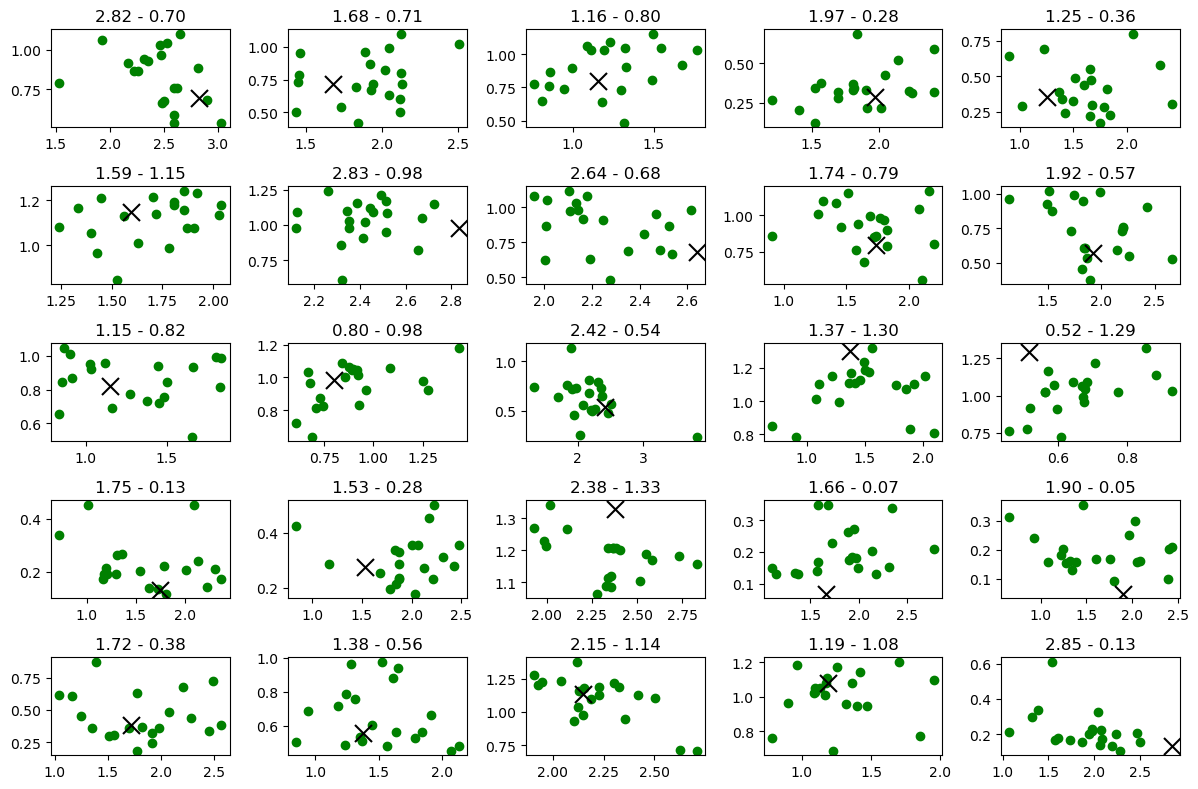

In [13]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

## Schlather

In [14]:
# Dataloader
exp = "exp_4_1"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [15]:
#Load model
net = CNN_test(channels=5)
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [16]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [17]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [18]:
# Schlather metrics
get_metrics(pred_tf,param_tf, model)

RMSE: [0.59 0.33]
MAE: [0.48 0.28]
IMSE: 0.52


In [19]:
# Plot results
n_comb = 25
n_each = 20

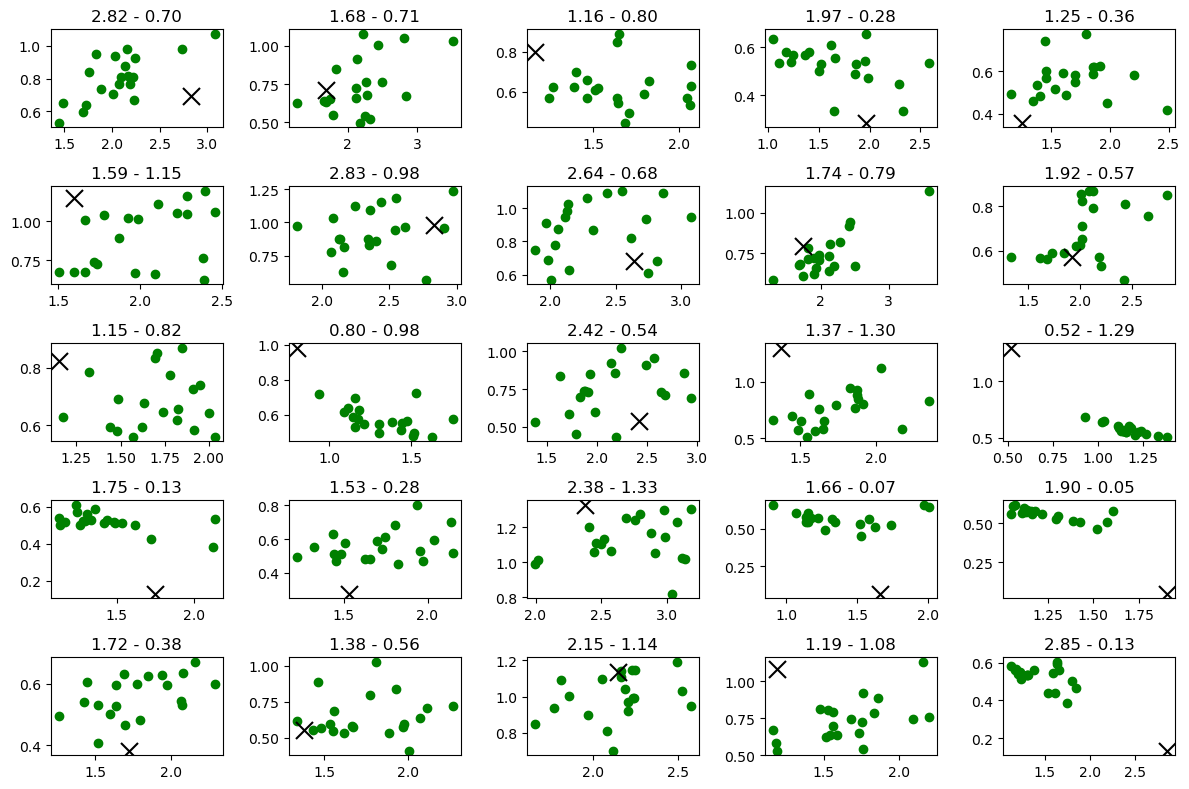

In [20]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()